In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_val_predict
from sklearn import metrics
import numpy as np
import pandas as pd
import pickle as pkl
import ast
import re

In [101]:
## OLD FUNCTION
# data = pd.read_csv(r'../datasets/RF-dataset.csv')
# for colname in ['name', 'keyword', 'common']:
#     data[colname] = data[colname].astype(int)
# data['label'] = [1 if x == 'nominal' else 0 for x in data['label']]
# #X, y = data.iloc[:, :-1], data['label']
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# X_train, X_test, y_train, y_test = data.iloc[:101, :-1], data.iloc[102:, :-1], data.iloc[:101, -1], data.iloc[102:, -1] 
# print(X_train)
# print(y_train)

In [3]:
# Import nominal and ordinal data gathered from src/gbc/heuristics.py
data_nom = pd.read_csv(r'../datasets/out_nominal.csv')
data_ord = pd.read_csv(r'../datasets/out_ordinal.csv')
data = pd.concat([data_nom, data_ord])

# Convert False/True to 0/1
for colname in ['name_nom','name_ord','key_nom','key_ord','common']:
    data[colname] = data[colname].astype(int)

# Take the mean of the variance, since there will be issues regarding the dimensionality otherwise
data['variance'] = data['variance'].apply(lambda x: np.mean(list(map(float, x.split('[')[1].split(']')[0].split()))))
data['label'] = [1 if x == 'nominal' else 0 for x in data['label']]

# Drop key_nom, as this feature is not used
data = data.drop('key_nom',axis=1)

# Split into data + label
X, y = data.iloc[:, :-1], data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X.to_string())
# print(X_train, X_test, y_train, y_test)

    total_entries  unique_entries     ratio     variance  name_nom  name_ord  key_ord  common
0           48691           47685  0.979339  3337.245700         1         0        0       0
1           48691           11386  0.233842  3992.517869         1         0        0       0
2           48691              76  0.001561    17.520780         1         0        0       0
3           48691             223  0.004580    55.020775         0         0        0       0
4           48691               3  0.000062     0.245778         1         0        0       0
5           19158             123  0.006420     2.897103         1         0        0       0
6           19158               6  0.000313     1.355629         0         0        0       0
7           19158               6  0.000313     1.296207         1         0        0       0
8             205             126  0.614634    42.625985         1         0        0       0
9            2405              99  0.041164    18.601082    

In [102]:
# Old classifier, not used anymore
#clf = RandomForestClassifier(n_estimators=300)

# Initialize the GBC and fit the model, then estimate its accuracy + F1-score
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("F1:", metrics.f1_score(y_test, y_pred))

Accuracy: 1.0
F1: 1.0


In [5]:
# Save the model
pkl.dump(clf, open('trained_gbc.sav', 'wb'))

In [13]:
# Estimate the model's performance using LOOCV, which might be more reliable given that we have little data
loo = LeaveOneOut()
y_true, y_pred = list(), list()

# Copied from https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
for train_ix, test_ix in loo.split(X):
    # split data
    X_train, X_test = X.iloc[list(train_ix), :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # fit model
    clf = GradientBoostingClassifier(max_depth=2, random_state=1)
    clf.fit(X_train, y_train)
    # evaluate model
    yhat = clf.predict(X_test)
    # store
    y_true.append(y_test.tolist()[0])
    y_pred.append(yhat[0])

# Evaluate our findings
acc = metrics.accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)
print("F1:", metrics.f1_score(y_true, y_pred))

Accuracy: 0.980
F1: 0.9781021897810219


In [95]:
# Now with test set = columns from datasets not considered in training data
X = pd.concat([data.iloc[15:, :-1], data.iloc[:88, :-1], data.iloc[103:, :-1]])
X_eval = pd.concat([data.iloc[:15, :-1], data.iloc[88:103, :-1]])
y = pd.concat([data.iloc[15:, -1], data.iloc[:88, -1], data.iloc[103:, -1]])
y_eval = pd.concat([data.iloc[:15, -1], data.iloc[88:103, -1]])

# Initialize + fit model + evaluate our findings
clf = GradientBoostingClassifier(max_depth=2)
clf.fit(X, y)
y_pred = clf.predict(X_eval)
print("Accuracy:", metrics.accuracy_score(y_eval, y_pred))
print("F1:", metrics.f1_score(y_eval, y_pred))

Accuracy: 1.0
F1: 1.0


In [33]:
# Same as the LOOCV in the above cells, but more compact.
from numpy import mean, std

ests = [25, 50, 75, 100, 125, 150, 175, 200]
# depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lrs = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
scores_lst = []
for j in lrs:
    print('now doing lr:', j)
    for i in ests:
        X, y = data.iloc[:, :-1], data['label']
        cv = LeaveOneOut()
        clf = GradientBoostingClassifier(random_state=0, learning_rate=j, n_estimators=i)
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    
# # Save this model
# clf.fit(X, y)
# pkl.dump(clf, open('trained_gbc.sav', 'wb'))

now doing lr: 0.005
Accuracy: 0.745 (0.436)
Accuracy: 0.926 (0.261)
Accuracy: 0.926 (0.261)
Accuracy: 0.926 (0.261)
Accuracy: 0.960 (0.197)
Accuracy: 0.926 (0.261)
Accuracy: 0.960 (0.197)
Accuracy: 0.960 (0.197)
now doing lr: 0.01
Accuracy: 0.919 (0.272)
Accuracy: 0.926 (0.261)
Accuracy: 0.926 (0.261)
Accuracy: 0.960 (0.197)
Accuracy: 0.960 (0.197)
Accuracy: 0.960 (0.197)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
now doing lr: 0.05
Accuracy: 0.960 (0.197)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
now doing lr: 0.1
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
now doing lr: 0.2
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.980 (0.140)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0.162)
Accuracy: 0.973 (0

In [39]:
from sklearn.metrics import confusion_matrix

In [54]:
# Confusion matrix + F1
X, y = data.iloc[:, :-1], data['label']
cv = LeaveOneOut()
clf = GradientBoostingClassifier(random_state=0)
scores = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)


[[79  2]
 [ 1 67]]
F1: 0.9781021897810219
Precision: 0.9710144927536232
Recall: 0.9852941176470589
ROC_AUC: 0.9803013798111837
(array([0.        , 0.02469136, 1.        ]), array([0.        , 0.98529412, 1.        ]), array([2, 1, 0], dtype=int64))


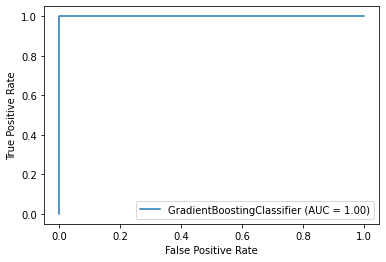

In [56]:
clf.fit(X, y)
print(conf_mat)
print("F1:", metrics.f1_score(y, y_pred))
print('Precision:', metrics.precision_score(y, y_pred))
print('Recall:', metrics.recall_score(y, y_pred))
print('ROC_AUC:', metrics.roc_auc_score(y, y_pred))
print(metrics.roc_curve(y, y_pred))
metrics.plot_roc_curve(clf, X, y)